In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('data/PJME_hourly.csv')

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

df = df.set_index('Datetime').sort_index() # sắp xếp theo thời gian để chuẩn hóa dữ liệu
df = df.resample('h').mean() # ấy trung bình nếu có nhiều điểm trong cùng 1 giờ

df['PJME_MW'] = df['PJME_MW'].interpolate(method='time') # nội suy giá trị thiếu theo thời gian

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145392 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


Epoch 1/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 216s 29ms/step - loss: 0.0055 - val_loss: 1.7293e-04
Epoch 2/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 211s 29ms/step - loss: 2.3223e-04 - val_loss: 6.4056e-05
Epoch 3/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 194s 27ms/step - loss: 1.3811e-04 - val_loss: 6.7580e-05
Epoch 4/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 189s 26ms/step - loss: 1.1651e-04 - val_loss: 5.4523e-05
Epoch 5/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 209s 29ms/step - loss: 1.0594e-04 - val_loss: 7.6526e-05
Epoch 6/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 217s 30ms/step - loss: 9.6314e-05 - val_loss: 5.5519e-05
Epoch 7/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 268s 37ms/step - loss: 9.2473e-05 - val_loss: 3.5087e-05
Epoch 8/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 180s 25ms/step - loss: 8.6762e-05 - val_loss: 3.7504e-05
Epoch 9/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 170s 23ms/step - loss: 8.5147e-05 - val_loss: 2.9886e-05
Epoch 10/50
7269/7269 ━━━━━━━━━━━━━━━━━━━━ 179s 25ms/step - loss: 8.0317e-05 - val_loss: 3.7174e-05
Epoch 11/50
7

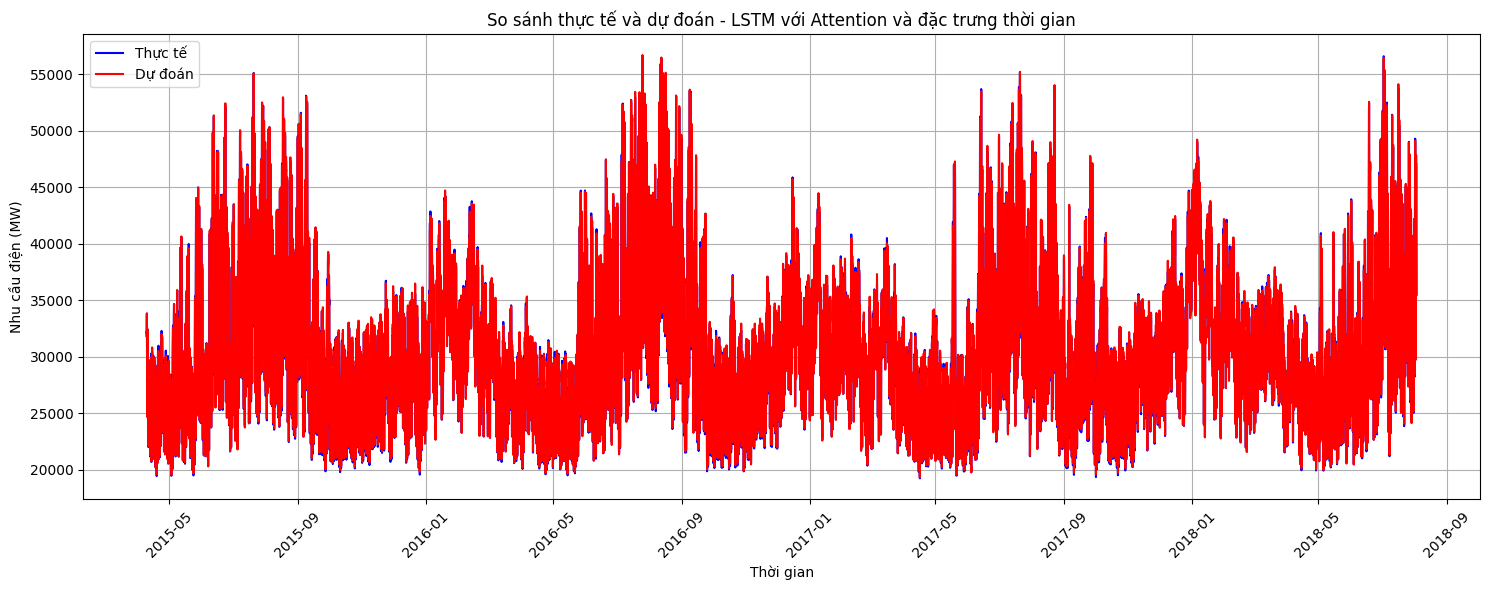

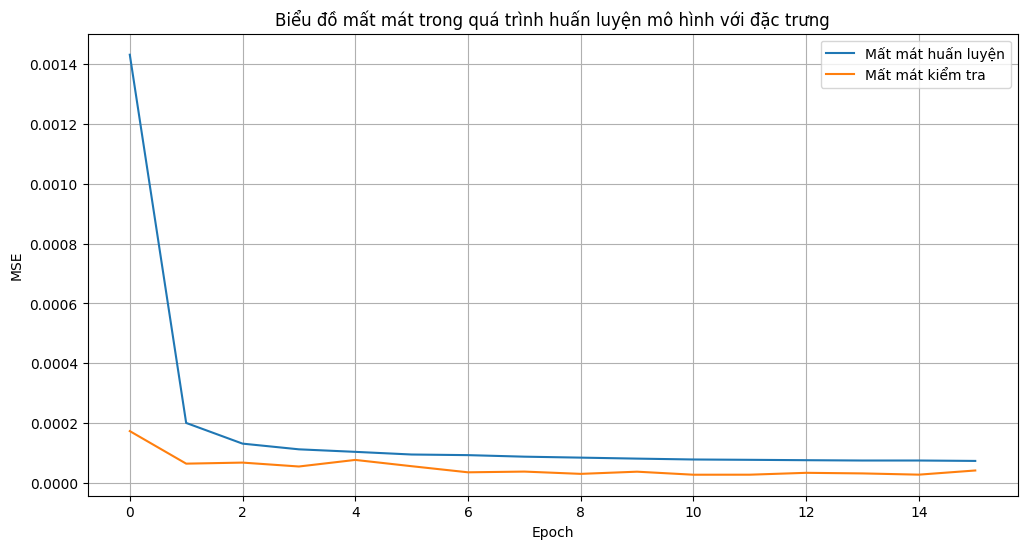

In [18]:
df_features = df.copy()
df_features['hour'] = df.index.hour
df_features['day'] = df.index.day  
df_features['month'] = df.index.month
df_features['season'] = ((df.index.month % 12) // 3).map({0: 0, 1: 1, 2: 2, 3: 3})  # 0:Đông, 1:Xuân, 2:Hè, 3:Thu

# CREATE FEATURE
def feature_engineering(df):
    df = df.copy()
    
    # TRỄ
    for lag in [1, 24, 168]:
        df[f'lag_{lag}h'] = df['PJME_MW'].shift(lag)
    
    # TRƯỢT
    for window in [24]:
        df[f'rolling_mean_{window}h'] = df['PJME_MW'].rolling(window=window).mean()
        df[f'rolling_std_{window}h'] = df['PJME_MW'].rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df['PJME_MW'].rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df['PJME_MW'].rolling(window=window).max()
    
    df['diff_1h'] = df['PJME_MW'].diff(1)
    df['diff_24h'] = df['PJME_MW'].diff(24)
    
    return df

def fillna(df):
    df = df.copy()
    
    for col in df.columns:
        if col.startswith('lag_'):
            df[col] = df.groupby(df.index.hour)[col].transform(lambda x: x.fillna(x.mean()))
    
    for window in [24]:
        mask = df[f'rolling_mean_{window}h'].isna()
        df.loc[mask, f'rolling_mean_{window}h'] = df.loc[mask, 'PJME_MW']
        df[f'rolling_std_{window}h'] = df[f'rolling_std_{window}h'].fillna(0)
        df.loc[mask, f'rolling_min_{window}h'] = df.loc[mask, 'PJME_MW']
        df.loc[mask, f'rolling_max_{window}h'] = df.loc[mask, 'PJME_MW']
    
    df['diff_1h'] = df['diff_1h'].fillna(0)
    df['diff_24h'] = df['diff_24h'].fillna(0)
    
    return df

df_features = feature_engineering(df_features)
df_features = fillna(df_features)

# 3. Chuẩn hóa dữ liệu
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

# Chuẩn hóa biến mục tiêu
scaled_target = scaler_target.fit_transform(df_features[['PJME_MW']])

# Chuẩn hóa các đặc trưng
features = [
    'hour', 'day', 'month', 'season',
    
    # Lag features
    'lag_1h', 'lag_24h', 'lag_168h',
    
    # Rolling statistics
    'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
    
    # Differencing
    'diff_1h', 'diff_24h'
]
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(df_features[features])

data = np.hstack((scaled_target, scaled_features))

def create_sequences_with_features(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0]) 
    return np.array(X), np.array(y)

seq_length = 24  # 24 giờ gần nhất dự đoán giờ tiếp theo
X_with_features, y_with_features = create_sequences_with_features(data, seq_length)

# 5. Tách train/test
train_size = int(len(X_with_features) * 0.8)
X_train_features = X_with_features[:train_size]
X_test_features = X_with_features[train_size:]
y_train_features = y_with_features[:train_size]
y_test_features = y_with_features[train_size:]

# Sử dụng attention + lstm 
inputs = Input(shape=(seq_length, X_with_features.shape[2]))  

lstm_out = LSTM(128, activation='tanh', return_sequences=True)(inputs)
lstm_out = LayerNormalization()(lstm_out)

attention = MultiHeadAttention(num_heads=4, key_dim=25)(lstm_out, lstm_out)
attention = LayerNormalization()(attention + lstm_out)  # Skip connection

lstm_out2 = LSTM(64, activation='tanh')(attention)
lstm_out2 = Dropout(0.1)(lstm_out2)

output = Dense(32, activation='relu')(lstm_out2)
outputs = Dense(1)(lstm_out2)

model_with_features = Model(inputs=inputs, outputs=outputs)
model_with_features.compile(optimizer='adam', loss='mse')

# HUẤN LUYỆN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_with_features = model_with_features.fit(
    X_train_features, y_train_features,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_features, y_test_features),
    callbacks=[early_stop],
    verbose=1
)

# DỰ BÁO
y_pred_features = model_with_features.predict(X_test_features, verbose=0)

y_test_features_inv = scaler_target.inverse_transform(y_test_features.reshape(-1, 1))
y_pred_features_inv = scaler_target.inverse_transform(y_pred_features)

# ĐÁNH GIÁ 
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae_features = mean_absolute_error(y_test_features_inv, y_pred_features_inv)
rmse_features = np.sqrt(mean_squared_error(y_test_features_inv, y_pred_features_inv))
mape_features = np.mean(np.abs((y_test_features_inv - y_pred_features_inv) / y_test_features_inv)) * 100

print(f"Kết quả đánh giá mô hình LSTM với Attention và đặc trưng thời gian:")
print(f"MAE: {mae_features:.2f} MW")
print(f"RMSE: {rmse_features:.2f} MW") 
print(f"MAPE: {mape_features:.2f}%")

test_dates_features = df.index[train_size + seq_length:]

plt.figure(figsize=(15, 6))
plt.plot(test_dates_features, y_test_features_inv, label='Thực tế', color='blue')
plt.plot(test_dates_features, y_pred_features_inv, label='Dự đoán', color='red')
plt.title('So sánh thực tế và dự đoán - LSTM với Attention và đặc trưng thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Nhu cầu điện (MW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_with_features.history['loss'], label='Mất mát huấn luyện')
plt.plot(history_with_features.history['val_loss'], label='Mất mát kiểm tra')
plt.title('Biểu đồ mất mát trong quá trình huấn luyện mô hình với đặc trưng')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()